<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/GloVe_Global_Vectors_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main advantage of GloVe over the previously described Word2vec techniques is that it pays attention to both global and local statistics of the corpus to learn embeddings. As GloVe are able to capture the global information about words, they tend to give better performance, especially when the corpus size increases. Another advantage is that unlike in Word2vec techniques, GloVe does not approximate the cost function (for example, Word2vec using negative sampling), but calculates the true cost. This leads to better and easier optimization of the loss.

Methods for learning word vectors fall into either of two categories: 
* global matrix factorization-based methods or 
* local context window-based methods. 

Latent Semantic Analysis (LSA) is an example of a global matrix factorization-based method, and skip-gram and CBOW are local context window-based methods.

LSA is used as a document analysis technique that maps words in the documents to something known as a concept, a common pattern of words that appears in a document. 

Global matrix factorization-based methods efficiently exploit the global statistics of a corpus (for example, co-occurrence of words in a global scope), but have shown to perform poorly at word analogy tasks. 

On the other hand, context window-based methods have been shown to perform well at word analogy tasks, but do not utilize global statistics of the corpus, leaving space for improvement. 

GloVe attempts to get the best of both worlds—an approach that efficiently leverages global corpus statistics while optimizing the learning model in a context window-based manner similar to skip-gram or CBOW.

The basic idea behind GloVe. To do so, let's consider an example:
1. Consider word i = "dog" and j = "cat"
2. Define an arbitrary probe word k
3. Define $P_{ik}$ to be the probability of words i and k occurring close to each other, and $P_{jk}$ to be the words j and k occurring together

Now let's look at how the  $\frac{P_{ik}}{P_{jk}}$ entity behaves with different values for k.

For k ="bark"  , it is highly likely to appear with i,thus, $P_{ik}$ will be high. However, k would not often appear along with j causing a low $P_{jk}$ . Therefore, we get the following expression:

$$\frac{P_{ik}}{P_{jk}} >> 1$$

Next, for k = "purr"  , it is unlikely to appear in the close proximity of i and therefore will have a low $P_{ik}$ ; however, since $k$ highly correlates with $j$, the value of $P_{jk}$ will be high. This leads to the following:

$$\frac{P_{ik}}{P_{jk}} \sim 0$$ 

Now, for words such as k = "pet" , which has a strong relationship with both
i and j, or k = "politics"  , where i and j, both have a minimal relevance to,
we get this:

$$\frac{P_{ik}}{P_{jk}} \sim 1$$ 

It can be seen that the  $\frac{P_{ik}}{P_{jk}}$ entity, which is calculated by measuring the frequency of two words appearing close to each other, is a good means for measuring the relationship between words. As a result, it becomes a good candidate for learning word vectors. 

In [ ]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import bz2
from matplotlib import pylab
import urllib
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
nltk.download('punkt') #tokenizers/punkt/PY3/english.pickle
from math import ceil

Instructions for updating:
non-resource variables are not supported in the long term
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


DRB-HIPCSOM-WP
* __D__OWNLOAD DATA
* __R__EAD DATA WITH RELEVANT PRE-PROC
* BUILD __B__ATCHES
* ___CO-OCCURENCE MATRIX___: This is a new step
* DEFINE __H__YPERPARAMETERS
* DEFINE __I__NPUTS AND OUTPUTS
* DEFINE MODEL __P__ARAMETERS
* DEFINE MODEL __C__OMPUTATIONS
* CALCULATE WORD __S__IMILARITIES
* DEFINE __O__PTIMIZER
* RUN __M__ODEL
* FIND __W__ORDS CLUSTERED TOGETHER
* COMPUTE T-SNE AND __P__LOT T-SNE

In [ ]:
# DOWNLOAD DATA

def download_data(url, filename):
  if not os.path.exists(filename):
    print('Downloading file:','\t',url)
    filename, _ = urllib.request.urlretrieve(url,filename)
  else:
    raise Exception("FILE ALREADY EXISTS!")
  return filename

url = 'https://github.com/amolnayak311/nlp-with-tensorflow/blob/master/wikipedia2text-extracted.txt.bz2?raw=true'
filename = 'wikipedia2text-extracted.txt.bz2'
filename = download_data(url,filename)

In [ ]:
# READ DATA WITH PREPROCESSING WITH NLTK
#
# Reads data as it is to a string, 
# convert to lower-case and 
# tokenize it using the nltk library. 
#
# This code reads data in 1MB portions as processing the full text at once 
# slows down the task and returns a list of words. 
# You will have to download the necessary tokenizer.

def read_data(filename):
  """
  Extract the first file enclosed in a zip file as a list of words
  and pre-processes it using the nltk python library
  """

  with bz2.BZ2File(filename) as f:

    data = []

    file_size = os.stat(filename).st_size
    # reading 1 MB at a time as the dataset is moderately large
    chunk_size = 1024 * 1024 
    print('Reading data...')
    
    for i in range(math.ceil(file_size//chunk_size)+1):
      bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
      file_string = f.read(bytes_to_read).decode('utf-8')
      file_string = file_string.lower()
      
      # tokenizes a string to words residing in a list
      file_string = nltk.word_tokenize(file_string)
      data.extend(file_string)
  return data


words = read_data(filename)
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Reading data...
Data size 3360286
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


In [ ]:
# BUILD DATASET

# we restrict our vocabulary size to 50000
vocabulary_size = 50000 

def build_dataset(words):
  count = [['UNK', -1]]
  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
    
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

Most common words (+UNK) [['UNK', 69215], ('the', 226881), (',', 184013), ('.', 120944), ('of', 116323)]
Sample data [1721, 9, 8, 16471, 223, 4, 5165, 4456, 26, 11590]


In [ ]:
# GENERATE BATCHES

data_index = 0

def generate_batch(batch_size, window_size):
  # data_index is updated by 1 everytime we read a data point
  global data_index 
    
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  weights = np.ndarray(shape=(batch_size), dtype=np.float32)

  # span defines the total window size, where
  # data we consider at an instance looks as follows. 
  # [ skip_window target skip_window ]
  span = 2 * window_size + 1 
    
  # The buffer holds the data contained within the span
  buffer = collections.deque(maxlen=span)
  
  # Fill the buffer and update the data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  # This is the number of context words we sample for a single target word
  num_samples = 2*window_size 

  # We break the batch reading into two for loops
  # The inner for loop fills in the batch and labels with 
  # num_samples data points using data contained withing the span
  # The outper for loop repeat this for batch_size//num_samples times
  # to produce a full batch
  for i in range(batch_size // num_samples):
    k=0
    # avoid the target word itself as a prediction
    # fill in batch and label numpy arrays
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      weights[i * num_samples + k] = abs(1.0/(j - window_size))
      k += 1 
    
    # Everytime we read num_samples data points,
    # we have created the maximum number of datapoints possible
    # withing a single span, so we need to move the span by 1
    # to create a fresh new span
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels, weights

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [2, 4]:
    data_index = 0
    batch, labels, weights = generate_batch(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('\t','batch:', [reverse_dictionary[bi] for bi in batch])
    print('\t','labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('\t','weights:', [w for w in weights])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with window_size = 2:
	 batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
	 labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']
	 weights: [0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]

with window_size = 4:
	 batch: ['set', 'set', 'set', 'set', 'set', 'set', 'set', 'set']
	 labels: ['propaganda', 'is', 'a', 'concerted', 'of', 'messages', 'aimed', 'at']
	 weights: [0.25, 0.33333334, 0.5, 1.0, 1.0, 0.5, 0.33333334, 0.25]


## Creating the Word Co-Occurance Matrix
Why GloVe shine above context window based method is that it employs global statistics of the corpus in to the model (according to authors). This is done by using information from the word co-occurance matrix to optimize the word vectors. Basically, the X(i,j) entry of the co-occurance matrix says how frequent word i to appear near j. We also use a weighting mechanishm to give more weight to words close together than to ones further-apart (from experiments section of the paper).

In [ ]:
# We are creating the co-occurance matrix as a compressed sparse colum matrix from scipy. 
cooc_data_index = 0
dataset_size = len(data) # We iterate through the full text
skip_window = 4 # How many words to consider left and right.

# The sparse matrix that stores the word co-occurences
cooc_mat = lil_matrix((vocabulary_size, vocabulary_size), dtype=np.float32)

print(cooc_mat.shape)
def generate_cooc(batch_size,skip_window):
    '''
    Generate co-occurence matrix by processing batches of data
    '''
    data_index = 0
    print('Running %d iterations to compute the co-occurance matrix'%(dataset_size//batch_size))
    for i in range(dataset_size//batch_size):
        # Printing progress
        if i>0 and i%100000==0:
            print('\tFinished %d iterations'%i)
            
        # Generating a single batch of data
        batch, labels, weights = generate_batch(batch_size, skip_window)
        labels = labels.reshape(-1)
        
        # Incrementing the sparse matrix entries accordingly
        for inp,lbl,w in zip(batch,labels,weights):            
            cooc_mat[inp,lbl] += (1.0*w)

# Generate the matrix
generate_cooc(8,skip_window)    

# Just printing some parts of co-occurance matrix
print('Sample chunks of co-occurance matrix')


# Basically calculates the highest cooccurance of several chosen word
for i in range(10):
    idx_target = i
    
    # get the ith row of the sparse matrix and make it dense
    ith_row = cooc_mat.getrow(idx_target)     
    ith_row_dense = ith_row.toarray('C').reshape(-1)        
    
    # select target words only with a reasonable words around it.
    while np.sum(ith_row_dense)<10 or np.sum(ith_row_dense)>50000:
        # Choose a random word
        idx_target = np.random.randint(0,vocabulary_size)
        
        # get the ith row of the sparse matrix and make it dense
        ith_row = cooc_mat.getrow(idx_target) 
        ith_row_dense = ith_row.toarray('C').reshape(-1)    
        
    print('\nTarget Word: "%s"'%reverse_dictionary[idx_target])
        
    sort_indices = np.argsort(ith_row_dense).reshape(-1) # indices with highest count of ith_row_dense
    sort_indices = np.flip(sort_indices,axis=0) # reverse the array (to get max values to the start)

    # printing several context words to make sure cooc_mat is correct
    print('Context word:',end='')
    for j in range(10):        
        idx_context = sort_indices[j]       
        print('"%s"(id:%d,count:%.2f), '%(reverse_dictionary[idx_context],idx_context,ith_row_dense[idx_context]),end='')
    print()

(50000, 50000)
Running 420035 iterations to compute the co-occurance matrix
	Finished 100000 iterations
	Finished 200000 iterations
	Finished 300000 iterations
	Finished 400000 iterations
Sample chunks of co-occurance matrix

Target Word: "UNK"
Context word:","(id:2,count:3354.47), "UNK"(id:0,count:2149.93), "the"(id:1,count:1967.01), "and"(id:5,count:1430.92), "."(id:3,count:1299.17), "of"(id:4,count:1051.58), "("(id:13,count:1035.75), ")"(id:12,count:810.08), "in"(id:6,count:748.00), "a"(id:8,count:616.83), 

Target Word: "ballet"
Context word:"the"(id:1,count:7.58), ","(id:2,count:7.08), "first"(id:49,count:2.50), "in"(id:6,count:2.33), "göteborg"(id:16299,count:1.75), "."(id:3,count:1.67), "of"(id:4,count:1.58), "to"(id:7,count:1.33), "queensland"(id:4946,count:1.33), "theatre"(id:869,count:1.25), 

Target Word: "azerbaijan"
Context word:"of"(id:4,count:2.33), "."(id:3,count:2.00), "the"(id:1,count:1.42), ","(id:2,count:1.33), "and"(id:5,count:1.33), "is"(id:9,count:1.00), "have"(i

In [ ]:
# DEFINE HYPERPARAMETERS
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

epsilon = 1 # used for the stability of log in the loss function

In [ ]:
# DEFINE INPUTS AND OUTPUTS

tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [ ]:
# DEFINE PARAMETERS

in_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
in_bias_embeddings = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

out_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
out_bias_embeddings = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

In [ ]:
# DEFINE COMPUTATIONS

# Look up embeddings for inputs and outputs
# Have two seperate embedding vector spaces for inputs and outputs
embed_in = tf.nn.embedding_lookup(in_embeddings, train_dataset)
embed_out = tf.nn.embedding_lookup(out_embeddings, train_labels)
embed_bias_in = tf.nn.embedding_lookup(in_bias_embeddings,train_dataset)
embed_bias_out = tf.nn.embedding_lookup(out_bias_embeddings,train_labels)

# weights used in the cost function
weights_x = tf.placeholder(tf.float32,shape=[batch_size],name='weights_x') 
# Cooccurence value for that position
x_ij = tf.placeholder(tf.float32,shape=[batch_size],name='x_ij')

# Compute the loss defined in the paper. Note that 
# I'm not following the exact equation given (which is computing a pair of words at a time)
# I'm calculating the loss for a batch at one time, but the calculations are identical.
# I also made an assumption about the bias, that it is a smaller type of embedding
loss = tf.reduce_mean(
    weights_x * (tf.reduce_sum(embed_in*embed_out,axis=1) + embed_bias_in + embed_bias_out - tf.log(epsilon+x_ij))**2)


In [ ]:
# SIMILARITIES

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
embeddings = (in_embeddings + out_embeddings)/2.0
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
# OPTIMIZERS

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# RUN MODELS
num_steps = 100001
glove_loss = []

average_loss = 0
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        
        # generate a single batch (data,labels,co-occurance weights)
        batch_data, batch_labels, batch_weights = generate_batch(
            batch_size, skip_window) 
        
        # Computing the weights required by the loss function
        batch_weights = [] # weighting used in the loss function
        batch_xij = [] # weighted frequency of finding i near j
        
        # Compute the weights for each datapoint in the batch
        for inp,lbl in zip(batch_data,batch_labels.reshape(-1)):     
            point_weight = (cooc_mat[inp,lbl]/100.0)**0.75 if cooc_mat[inp,lbl]<100.0 else 1.0 
            batch_weights.append(point_weight)
            batch_xij.append(cooc_mat[inp,lbl])
        batch_weights = np.clip(batch_weights,-100,1)
        batch_xij = np.asarray(batch_xij)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss. Specifically we provide
        # train_dataset/train_labels: training inputs and training labels
        # weights_x: measures the importance of a data point with respect to how much those two words co-occur
        # x_ij: co-occurence matrix value for the row and column denoted by the words in a datapoint
        feed_dict = {train_dataset : batch_data.reshape(-1), train_labels : batch_labels.reshape(-1),
                    weights_x:batch_weights,x_ij:batch_xij}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        if step % 2000 == 0:
          if step > 0:
            average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step %d: %f' % (step, average_loss))
          glove_loss.append(average_loss)
          average_loss = 0
        
        # Here we compute the top_k closest words for a given validation word
        # in terms of the cosine distance
        # We do this for all the words in the validation set
        # Note: This is an expensive step
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log = '%s %s,' % (log, close_word)
            print(log)
            
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 10.219233
Nearest to also: gazing, remixing, 640,000, czechoslovakia, deciduous, higgs, wished, loves,
Nearest to not: 15.5, antidiscrimination, garvey, startled, haka, kievan, glides, swarm,
Nearest to most: fluctuate, tandem, ketil, 1874., 68,667, overwhelmed, topologically, impoverishment,
Nearest to 's: trash, conservatives, acid, dances, epr, schnyder, 112,000, ven,
Nearest to of: ,, in, its, is, bernician, forty-five, gelememiş, 1644.,
Nearest to but: condiments, shattered, huyton, decapitation, undefeated, unscheduled, precluding, zeitschrift,
Nearest to the: ., in, merlot, suing, reintegrate, highrise, hannibal, rondvatnet,
Nearest to in: the, of, ., jūnzǐ, al-andalus, kertosudiro, unwieldy, toledo,
Nearest to been: 1815., dilute, supermarkets, giles, jenny, uptown, dishonour, omani,
Nearest to its: benign, of, infinitely, julie, growth, ohio, curaray, non-military,
Nearest to as: infinity, cool-season, franchise, solid, piecemeal, ||style=, 

# Document Embedding

This code downloads a dataset consisting of several BBC news articles belonging to various categories (e.g. sport, politics, etc.). 

We have two functions read_data which reads `files_to_read_for_topic` files from each category and `read_test_data` which set aside 10 documents from the read documents for testing purposes.

In [ ]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'
filename = 'bbc-fulltext.zip'

In [ ]:
filename = download_data(url,filename)

In [ ]:
import zipfile

In [ ]:
def read_data(filename):
  """
  Extract articles up to a given threshold in a zip file as a list of words
  and pre-processes it using the nltk python library
  """
  data = []
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tFinished reading data for topic: ',t)
        for fi in range(1,files_to_read_for_topic):
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)
                data.extend(file_string)
                
    return data

def read_test_data(filename):
  """
  Extract articles up to a given threshold in a zip file as a list of words
  and pre-processes it using the nltk python library
  """
  test_data = {}
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tFinished reading data for topic: ',t)
            
        for fi in np.random.randint(1,files_to_read_for_topic,(10)).tolist():
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)
                test_data[t+'-'+str(fi)] = file_string
                
    return test_data

print('Processing training data...')
words = read_data(filename)
print('\nProcessing testing data...')
test_words = read_test_data(filename)

print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Processing training data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech

Processing testing data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech
Example words (start):  ['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us']
Example words (end):  ['almost', '200,000', 'people', 'are', 'registered', 'players', 'on', 'project', 'entropia', '.']


In [ ]:
vocabulary_size = 25000

def build_dataset(words):
  # Allocate a special token for rare words
  count = [['UNK', -1]]

  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))


  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
    
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
    
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size

  return data, count, dictionary, reverse_dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Here we use this function to convert word strings to IDs
    with a given dictionary
    '''
    data = list()
    for word in words:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
        data.append(index)
    return data

# Processining training data
data, count, dictionary, reverse_dictionary = build_dataset(words)

# Processing test data
test_data = {}
for k,v in test_words.items():
    print('Building Test Dataset for ',k,' topic')
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('test keys: ',test_data.keys())

Building Test Dataset for  business-167  topic
Building Test Dataset for  business-44  topic
Building Test Dataset for  business-38  topic
Building Test Dataset for  business-170  topic
Building Test Dataset for  business-55  topic
Building Test Dataset for  business-154  topic
Building Test Dataset for  business-129  topic
Building Test Dataset for  business-190  topic
Building Test Dataset for  business-51  topic
Building Test Dataset for  business-123  topic
Building Test Dataset for  entertainment-47  topic
Building Test Dataset for  entertainment-227  topic
Building Test Dataset for  entertainment-147  topic
Building Test Dataset for  entertainment-226  topic
Building Test Dataset for  entertainment-86  topic
Building Test Dataset for  entertainment-244  topic
Building Test Dataset for  entertainment-245  topic
Building Test Dataset for  entertainment-235  topic
Building Test Dataset for  entertainment-154  topic
Building Test Dataset for  entertainment-159  topic
Building Test Da

In [ ]:
data_index = 0

def generate_batch(data, batch_size, window_size):
    # data_index is updated by 1 everytime we read a data point
    global data_index
    
    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    span = 2 * window_size + 1
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # This is the number of context words we sample for a single target word
    num_samples = 2*window_size 

    # We break the batch reading into two for loops
    # The inner for loop fills in the batch and labels with 
    # num_samples data points using data contained withing the span
    # The outper for loop repeat this for batch_size//num_samples times
    # to produce a full batch
    for i in range(batch_size // num_samples):
      k=0
      # avoid the target word itself as a prediction
      # fill in batch and label numpy arrays
      for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
        batch[i * num_samples + k] = buffer[window_size]
        labels[i * num_samples + k, 0] = buffer[j]
        k += 1 
    
      # Everytime we read num_samples data points,
      # we have created the maximum number of datapoints possible
      # withing a single span, so we need to move the span by 1
      # to create a fresh new span
      buffer.append(data[data_index])
      data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch(data, batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with window_size = 1:
    batch: [['sales', 'sales'], ['sales', 'sales'], ['boost', 'boost'], ['boost', 'boost'], ['time', 'time'], ['time', 'time'], ['warner', 'warner'], ['warner', 'warner']]
    labels: ['ad', 'boost', 'sales', 'time', 'boost', 'warner', 'time', 'profit']

with window_size = 2:
    batch: [['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time']]
    labels: ['ad', 'sales', 'time', 'warner', 'sales', 'boost', 'warner', 'profit']


In [ ]:
test_data_index = 0

def generate_test_batch(data, batch_size):
    '''
    Generate a batch of data from the test data
    This is used to compute the document embedding
    by taking the average of all the words in a document
    '''
    global test_data_index

    batch = np.ndarray(shape=(batch_size,), dtype=np.int32)
    # Get words starting from index 0 to span
    for bi in range(batch_size):
        batch[bi] = data[test_data_index]
        test_data_index = (test_data_index + 1) % len(data)

    return batch

test_data_index = 0
test_batch = generate_test_batch(test_data[list(test_data.keys())[0]], batch_size=8)
print('\nwith window_size = %d:' % (window_size))
print('\t','labels:', [reverse_dictionary[li] for li in test_batch.reshape(8)])


with window_size = 2:
	 labels: ['hariri', 'killing', 'hits', 'beirut', 'shares', 'shares', 'in', 'solidere']


## CBOW

In [ ]:
# HYPERPARAMETERS

batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

In [ ]:
# INPUTS AND OUTPUTS

tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])

# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data used to evaluate the word vectors
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Test data. This is used to compute the document embeddings by averaging
# word embeddings of a given document
test_labels = tf.placeholder(tf.int32, shape=[batch_size],name='test_dataset')

In [ ]:
# PARAMETERS

# embedding, vector for each word in the vocabulary
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size],dtype=tf.float32))

In [ ]:
# COMPUTATIONS

# Used to compute document embeddings by averaging all the word vectors of a 
# given batch of test data
mean_batch_embedding = tf.reduce_mean(tf.nn.embedding_lookup(embeddings,test_labels),axis=0)
    
# Model.
# Look up embeddings for all the context words of the inputs.
# Then compute a tensor by staking embeddings of all context words
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

# Make sure the staked embeddings have 2*window_size columns
assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

# Compute mean embeddings by taking the mean of the tensor containing the stack of embeddings
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())


Defining 8 embedding lookups representing each word in the context
Stacked embedding size: [128, 128, 8]
Reduced mean embedding size: [128, 128]


In [ ]:
# LOSS - THIS IS DIFFERENT

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings

# If you see the warning
# WARNING:tensorflow:From c:\...\lib\site-packages\tensorflow\python\ops\nn_impl.py:1346: 
# softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and 
# will be removed in a future version.
# You can ignore this. This caused by the internally used softmax_cross_entropy_with_logits function
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

In [ ]:
# SIMILARITY
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
# OPTIMIZER

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# MODEL

num_steps = 100001
cbow_loss = []

config=tf.ConfigProto(allow_soft_placement=True)
# This is an important setting and with limited GPU memory,
# not using this option might lead to the following error.
# InternalError (see above for traceback): Blas GEMM launch failed : ...
config.gpu_options.allow_growth = True

with tf.Session(config=config) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch(data, batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step+1, average_loss))
            cbow_loss.append(average_loss)
            average_loss = 0
        
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    
    # Computing test documents embeddings by averaging word embeddings
    
    # We take batch_size*num_test_steps words from each document
    # to compute document embeddings
    num_test_steps = 100
    
    # Store document embeddings
    # {document_id:embedding} format
    document_embeddings = {}
    print('Testing Phase (Compute document embeddings)')
    
    # For each test document compute document embeddings
    for k,v in test_data.items():
        print('\tCalculating mean embedding for document ',k,' with ', num_test_steps, ' steps.')
        test_data_index = 0
        topic_mean_batch_embeddings = np.empty((num_test_steps,embedding_size),dtype=np.float32)
        
        # keep averaging mean word embeddings obtained for each step
        for test_step in range(num_test_steps):
            test_batch_labels = generate_test_batch(test_data[k],batch_size)
            batch_mean = session.run(mean_batch_embedding,feed_dict={test_labels:test_batch_labels})
            topic_mean_batch_embeddings[test_step,:] = batch_mean
        document_embeddings[k] = np.mean(topic_mean_batch_embeddings,axis=0)


Initialized
Average loss at step 2000: 3.914601
Average loss at step 4000: 3.564329
Average loss at step 6000: 3.540692
Average loss at step 8000: 3.537623
Average loss at step 10000: 3.473169
Nearest to more: discrepancy, poses, curbs, project, famous, seychelles, totality, 2mbps,
Nearest to mr: he, eviction, realplayer, non-emergency, barnett, nou, scrolls, december,
Nearest to will: would, to, upmarket, himself, should, is, cobblestones, can,
Nearest to he: it, mr, 98, hinckley/brentford, she, patrolling, fisher, dozens,
Nearest to it: he, i, that, ``, this, there, 4/6, trutnev,
Nearest to ``: it, emails, mid-october, mp3, lick, proceedings, sealing, disused,
Nearest to was: is, o'neil, patrolling, 6.5bn, hickey, were, fcc, rapper,
Nearest to ,: ., the, 's, '', co-production, hurling, has, lulu,
Nearest to also: echo, acting, directed, but, included, said, finalist, â£86m,
Nearest to -: and, â£352m, ., scoggins, panke, freefall, 3bn, miserable,
Nearest to with: eponymous, haralabos,

In [ ]:
## Visualizing documents with t-SNE
# Defining a t-SNE and fitting data
# Number of data points to visualize
num_points = 1000 

# Create a t-SNE object
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE')
# get the T-SNE manifold
doc_ids, doc_embeddings = zip(*document_embeddings.items())
two_d_embeddings = tsne.fit_transform(doc_embeddings)
print('\tDone')

Fitting embeddings to T-SNE
	Done


In [ ]:
import matplotlib.pyplot as plt

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

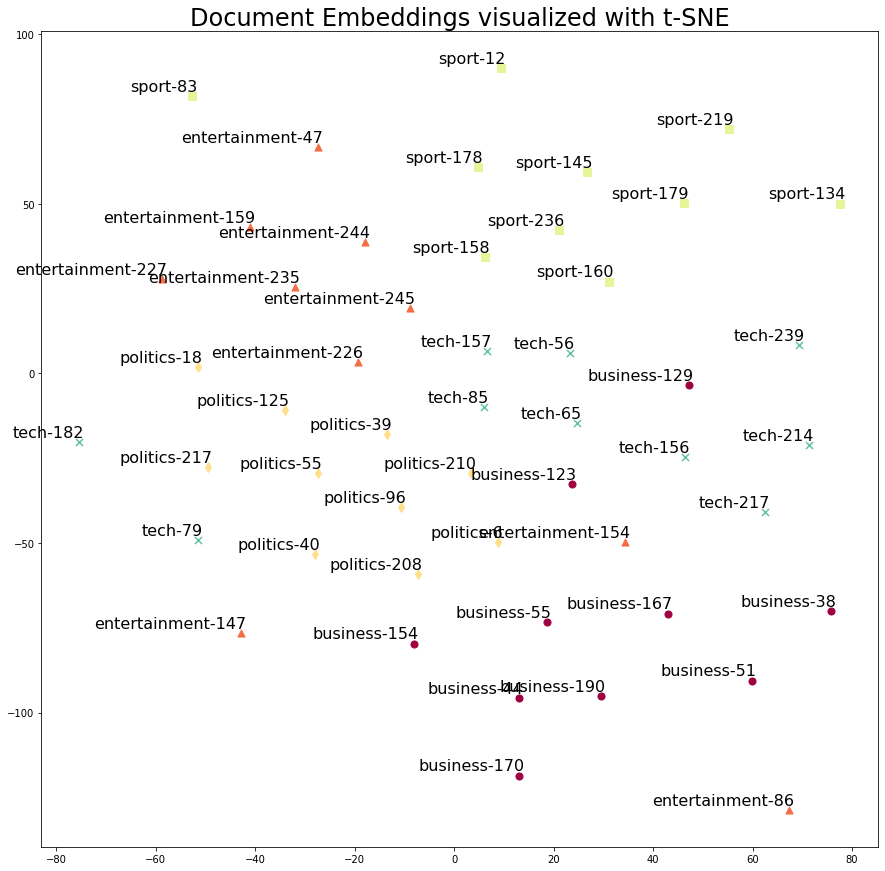

In [ ]:
# PLOTTING
def plot(embeddings, labels):
  
  n_clusters = 5 # number of clusters
    
  # automatically build a discrete set of colors, each for cluster
  label_colors = [plt.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
  label_markers = ['o','^','d','s','x']
  # make sure the number of document embeddings is same as
  # point labels provided
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  pylab.figure(figsize=(15,15))  # in inches

  def get_label_id_from_key(key):
    '''
    We assign each different category a cluster_id
    This is assigned based on what is contained in the point label
    Not the actual clustering results
    '''
    if 'business' in key:
        return 0
    elif 'entertainment' in key:
        return 1
    elif 'politics' in key:
        return 2
    elif 'sport' in key:
        return 3
    elif 'tech' in key:
        return 4
            
  # Plot all the document embeddings and their corresponding words
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=label_colors[get_label_id_from_key(label)],s=50,
                  marker=label_markers[get_label_id_from_key(label)])    
    
    # Annotate each point on the scatter plot
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)
  
  # Set plot title
  pylab.title('Document Embeddings visualized with t-SNE',fontsize=24)
  
  # Use for saving the figure if needed
  pylab.savefig('document_embeddings.png')
  pylab.show()

# Run the plotting function
plot(two_d_embeddings, doc_ids)

## Perform Document Classification
Here we first cluster the document embeddings by means of K-means. K-means is a popular and simple clustering algorithm. Then we will list what is contained in each cluster. Each cluster should roughly contain documents belonging to a single category. You can use the same information to classify an unseen document using the following steps.

Compute the document embeddings for test document
Compute K-means using all the previous documents + the new document
Label the new test document to be of the category most of it's neighbors belong to

In [ ]:
# Create and fit K-means
kmeans = KMeans(n_clusters=5, random_state=43643, max_iter=10000, n_init=100, algorithm='elkan')
kmeans.fit(np.array(list(document_embeddings.values())))

# Compute items fallen within each cluster
document_classes = {}
for inp, lbl in zip(list(document_embeddings.keys()), kmeans.labels_):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)
for k,v in document_classes.items():    
    print('\nDocuments in Cluster ',k)
    print('\t',v)


Documents in Cluster  2
	 ['business-167', 'business-44', 'business-38', 'business-170', 'business-55', 'business-154', 'business-129', 'business-190', 'business-51']

Documents in Cluster  4
	 ['business-123', 'entertainment-227', 'entertainment-147', 'entertainment-226', 'entertainment-244', 'entertainment-245', 'entertainment-235', 'entertainment-154', 'entertainment-159', 'politics-96', 'politics-208', 'politics-217', 'politics-210', 'politics-55', 'politics-39', 'politics-18', 'politics-125', 'politics-40', 'politics-6', 'tech-182', 'tech-239', 'tech-79', 'tech-157', 'tech-56', 'tech-214', 'tech-217', 'tech-65', 'tech-85', 'tech-156']

Documents in Cluster  1
	 ['entertainment-47', 'entertainment-86', 'sport-83', 'sport-12']

Documents in Cluster  0
	 ['sport-179', 'sport-145', 'sport-178', 'sport-236', 'sport-219', 'sport-160', 'sport-158']

Documents in Cluster  3
	 ['sport-134']
